[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fY_ZT2Ng5qjW3rC0F3jMjYnrqdjTfYun?usp=sharing)

# Usando TFX no Vertex AI

Nesse notebook iremos criar e executar um Pipeline do TFX (o mesmo utilizado na [última aula](https://github.com/tensorflow-sp/tfx-iniciantes-2022/blob/main/Ep5/TFX_Pipelines_Deployment_de_modelos.ipynb)) para treinar e servir um modelo no Vertex AI.

## Introdução

### Motivação

Sabemos que rodar no notebook na vida real não rola. Então, como podemos dar o próximo passo e tornar todo nosso conhecimento e pipeline montado em algo que possa ser utilizado na vida real? A resposta é: Utilizando TFX + Vertex AI.

### Pipeline que iremos construir no Vertex AI

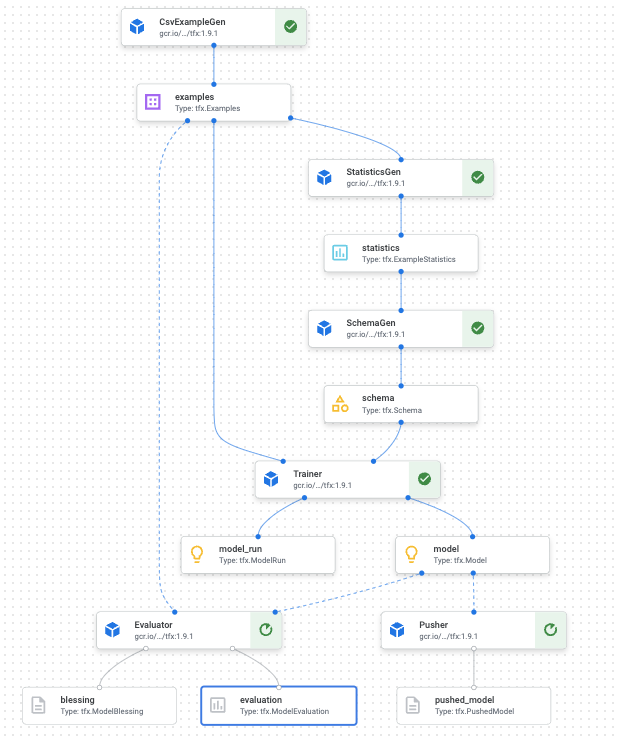

## Execução

### Configuração do ambiente

In [1]:
# Garantir que temos a biblioteca colab e que o pip está atualizado
try:
  import colab
  !pip install --upgrade pip
except:
  pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
# Instalando TFX
!pip install tfx[kfp]==1.9.1 "shapely<2" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Após a instalação, reinicie seu ambiente para garantir que o Colab veja o TFX. Para isso, clique em "Ambiente de execução" $\rightarrow$ "Reiniciar ambiente de execução".

Feito isso, comece a executar a partir da próxima célula.

In [1]:
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TFX version: 1.9.1


### Iniciando nosso experimento

In [2]:
import os

# Vamos definir os nomes dos nossos pipelines para definirmos
# as pastas onde iremos salvas os artefatos gerados
PIPELINE = "iris"

# Pastas onde iremos salvar os outputs
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE)

# Caminho para o banco de dados SQLite que usaremos como nosso banco de metadata
METADATA_PIPELINE_PATH = os.path.join('metadata', PIPELINE, 'metadata.db')

#### Preparando os dados



In [3]:
import urllib.request
import tempfile

DATA_ROOT = tempfile.mkdtemp(prefix='tfx-data')  # Criando pasta temporária
_data_url = 'https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/datasets/iris.csv'
_data_filepath = os.path.join(DATA_ROOT, "data.csv")
urllib.request.urlretrieve(_data_url, _data_filepath)

('/tmp/tfx-datadijyqi15/data.csv', <http.client.HTTPMessage at 0x7fb0753d85e0>)

In [4]:
import pandas as pd

df = pd.read_csv(_data_filepath, index_col=0)
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [5]:
!mkdir data
!mkdir data/train
!mkdir data/eval

In [6]:
df.to_csv('data/iris.csv', index = False)
df['Species'] = df['Species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
df = df.sample(frac=1)
df_train = df.iloc[:100]
df_eval  = df.iloc[100:]
df_train.to_csv('data/train/iris_train.csv', index = False)
df_eval.to_csv('data/eval/iris_eval.csv', index = False)

### Pipeline da aula passada: Trainer e Evaluator

In [7]:
from tfx.proto import example_gen_pb2
from tfx.v1.proto import Input

In [10]:
_trainer_module_file = 'iris_trainer.py'

In [11]:
%%writefile {_trainer_module_file}

# Copied from https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple

from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils

from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_metadata.proto.v0 import schema_pb2

_LABEL_KEY = 'Species'

_TRAIN_BATCH_SIZE = 100
_EVAL_BATCH_SIZE = 50

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _make_keras_model(schema: schema_pb2.Schema) -> tf.keras.Model:
  """Creates a DNN Keras model for classifying iris data.

  Returns:
    A Keras Model.
  """
  feature_keys = [f.name for f in schema.feature if f.name != _LABEL_KEY]
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in feature_keys]
  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(10, activation='linear')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  schema = tfx.utils.parse_pbtxt_file(fn_args.schema_path, schema_pb2.Schema())

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _make_keras_model(schema)

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=fn_args.model_run_dir, update_freq='batch')

  model.fit(
      train_dataset,
      epochs=20,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')

Writing iris_trainer.py


In [12]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(label_key='Species')
        ],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
                   tfma.MetricsSpec(metrics=[
                      tfma.MetricConfig(class_name='ExampleCount'),
                   ])
    ]
)

### Pipeline com deploy local

In [13]:
def _create_pusher_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  
  trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_trainer_module_file),
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    train_args=tfx.proto.TrainArgs(num_steps=1),
    eval_args=tfx.proto.EvalArgs(num_steps=1))

  evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)

  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory="/content/models-to-serve/iris-model"))
    )

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      trainer,
      evaluator,
      pusher
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [14]:
tfx.orchestration.LocalDagRunner().run(
  _create_pusher_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data',
      metadata_path=METADATA_PIPELINE_PATH))

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 3.1242 - sparse_categorical_accuracy: 0.2600 - val_loss: 2.1995 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 83ms/step - loss: 2.4667 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.8856 - val_sparse_categorical_accuracy: 0.2600
Epoch 3/20
1/1 [==============================] - 0s 39ms/step - loss: 2.0262 - sparse_categorical_accuracy: 0.2800 - val_loss: 1.6922 - val_sparse_categorical_accuracy: 0.3400
Epoch 4/20
1/1 [==============================] - 0s 38ms/step - loss: 1.7251 - sparse_categorical_accuracy: 0.3300 - val_loss: 1.5671 - val_sparse_categorical_accuracy: 0.3400
Epoch 5/20
1/1 [==============================] - 0s 42ms/step - loss: 1.5071 - sparse_categorical_accuracy: 0.3300 - val_loss: 1.5348 - val_sparse_categorical_accuracy: 0.0400
Epoch 6/20
1/1 [==============================] - 0s 39ms/step - loss: 1.4004 - sparse_categorical_accuracy: 

## Treinando e deployando no Vertex AI

In [15]:
from google.colab import auth
auth.authenticate_user()

In [16]:
project_id = "mlops-368518"  # Mudar para o nome do seu projeto
gcp_region = "us-central1"  # Mudar para a região que estiver utilizando

In [37]:
!gsutil cp -r /content/data gs://tfx_vertexai_tutorial
!gsutil cp iris_trainer.py gs://tfx_vertexai_tutorial/iris_trainer.py

Copying file:///content/data/iris.csv [Content-Type=text/csv]...
Copying file:///content/data/eval/iris_eval.csv [Content-Type=text/csv]...
Copying file:///content/data/train/iris_train.csv [Content-Type=text/csv]...
/ [3 files][  6.5 KiB/  6.5 KiB]                                                
Operation completed over 3 objects/6.5 KiB.                                      
Copying file://iris_trainer.py [Content-Type=text/x-python]...
/ [1 files][  3.1 KiB/  3.1 KiB]                                                
Operation completed over 1 objects/3.1 KiB.                                      


In [54]:
from tfx.orchestration.kubeflow import kubeflow_dag_runner

vertex_training_args = {
    "project": project_id,
    "worker_pool_specs": [
        {
            "machine_spec": {
                "machine_type": "n1-highmem-8",
            },
            "replica_count": 1,
            "container_spec": {
                "image_uri": "gcr.io/tfx-oss-public/tfx:{}".format(tfx.__version__),
            },
        }
    ],
}

vertex_training_custom_config = {
    tfx.extensions.google_cloud_ai_platform.ENABLE_UCAIP_KEY: True,
    tfx.extensions.google_cloud_ai_platform.UCAIP_REGION_KEY: gcp_region,
    tfx.extensions.google_cloud_ai_platform.TRAINING_ARGS_KEY: vertex_training_args,
    "use_gpu": False,
}

vertex_serving_spec = {
    "project_id": project_id,
    "endpoint_name": "iris_model",
    "deployed_model_display_name": "iris_model",
    "machine_type": "n1-standard-2",
    "min_replica_count": 1,
    "max_replica_count": 2,
    "metadata": (("model_name", "iris_model"),),
}

vertex_container_image_uri = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest"

vertex_serving_args = {
    tfx.extensions.google_cloud_ai_platform.ENABLE_VERTEX_KEY: True,
    tfx.extensions.google_cloud_ai_platform.VERTEX_REGION_KEY: gcp_region,
    tfx.extensions.google_cloud_ai_platform.VERTEX_CONTAINER_IMAGE_URI_KEY: vertex_container_image_uri,
    tfx.extensions.google_cloud_ai_platform.SERVING_ARGS_KEY: vertex_serving_spec,
}


In [55]:
def build_pipeline(pipeline_name: str,
                   pipeline_root: str,
                   data_root: str,
                   trainer_file: str,
                   training_steps: int,
                   vertex_training_custom_config: dict = None,
                   vertex_serving_args: dict = None,) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""

  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  

  if vertex_training_custom_config:    
        trainer = tfx.extensions.google_cloud_ai_platform.Trainer(
            module_file=trainer_file,
            examples=example_gen.outputs['examples'],
            schema=schema_gen.outputs['schema'],
            train_args=tfx.proto.TrainArgs(num_steps=training_steps),
            eval_args=tfx.proto.EvalArgs(num_steps=1),
            custom_config=vertex_training_custom_config)
  else:
      trainer = tfx.components.Trainer(
        module_file=os.path.abspath(_trainer_module_file),
        examples=example_gen.outputs['examples'],
        schema=schema_gen.outputs['schema'],
        train_args=tfx.proto.TrainArgs(num_steps=training_steps),
        eval_args=tfx.proto.EvalArgs(num_steps=1))
  

  evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)

  if vertex_serving_args:
      pusher = tfx.extensions.google_cloud_ai_platform.Pusher(
          model=trainer.outputs["model"],
          custom_config=vertex_serving_args,
      )

  else:
    pusher = tfx.components.Pusher(
        model=trainer.outputs['model'],
        push_destination=tfx.proto.PushDestination(
            filesystem=tfx.proto.PushDestination.Filesystem(
                base_directory="/content/models-to-serve/iris-model"))
      )

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      trainer,
      evaluator,
      pusher
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      components=components)

In [56]:
p = build_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=os.path.join("gs://tfx_vertexai_tutorial", PIPELINE_ROOT),
      data_root=os.path.join("gs://tfx_vertexai_tutorial", "data"),
      trainer_file=os.path.join("gs://tfx_vertexai_tutorial", _trainer_module_file),
      training_steps=1,
      vertex_training_custom_config=vertex_training_custom_config,
      vertex_serving_args=vertex_serving_args
    )

In [57]:
metadata_config = kubeflow_dag_runner.get_default_kubeflow_metadata_config()

_ = tfx.orchestration.experimental.KubeflowV2DagRunner(
    config=tfx.orchestration.experimental.KubeflowV2DagRunnerConfig(),
    output_dir="/content",
    output_filename="pipe.json",
).run(p)

In [58]:
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

In [59]:
aiplatform.init(project=project_id, location=gcp_region)

job = pipeline_jobs.PipelineJob(template_path="/content/pipe.json",
                                display_name="tfx-vertex")
job.run(sync=True)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/iris-20221220042727?project=521833324333


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/iris-20221220042727?project=521833324333


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob run completed. Resource name: projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/521833324333/locations/us-central1/pipelineJobs/iris-20221220042727
